In [1]:
import os
import time

import dill as pickle

import functools
import operator
from datetime import datetime, timedelta
from multiprocessing import Pool
import shutil

import numpy as np
import pandas as pd
pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from covid_model_deaths.data import get_input_data, plot_crude_rates, DeathModelData
from covid_model_deaths.social_distancing_cov import SocialDistCov
from covid_model_deaths.drawer import Drawer
from covid_model_deaths.utilities import CompareModelDeaths, MOBILITY_SOURCES, KS, RATE_THRESHOLD, submit_curvefit, get_peak_date
from covid_model_deaths.impute_death_threshold import impute_death_threshold
from covid_model_deaths.moving_average import moving_average_predictions
from covid_model_deaths.compare_moving_average import CompareAveragingModelDeaths

from db_queries import get_location_metadata

import warnings
warnings.simplefilter('ignore')

RUN_TYPE = 'prod'
DATESTAMP_LABEL = '2020_04_18_US'
DATA_VERSION = 'best'
PEAK_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14/final_peak_locs_04_14.csv'
CASES_DEATHS_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14/deaths_from_cases.csv'
# PEAK_DURATION_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14/smooth_peak_duration.csv'
# R0_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14/R0_dates.csv'

# ensemble plot settings
COLOR_DICT = {
    'safegraph':'dodgerblue',
    'google':'forestgreen',
    'descartes':'firebrick',
    # 'R0_35':'gold',
    # 'R0_50':'darkgrey',
    # 'R0_65':'darkviolet'
}
LINE_DICT = {
    #'14':'-',
    '21':'--'
}


In [2]:
CODE_DIR = os.path.abspath('../src/covid_model_deaths')
OUTPUT_DIR = f'/ihme/covid-19/deaths/{RUN_TYPE}/{DATESTAMP_LABEL}'

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
print(f'Writing to {OUTPUT_DIR}')


Writing to /ihme/covid-19/deaths/prod/2020_04_18_US


In [3]:
print(CODE_DIR)

/ihme/homes/aucarter/covid19-modelling/covid-model-deaths/src/covid_model_deaths


## read full (unrestricted) set from snapshot

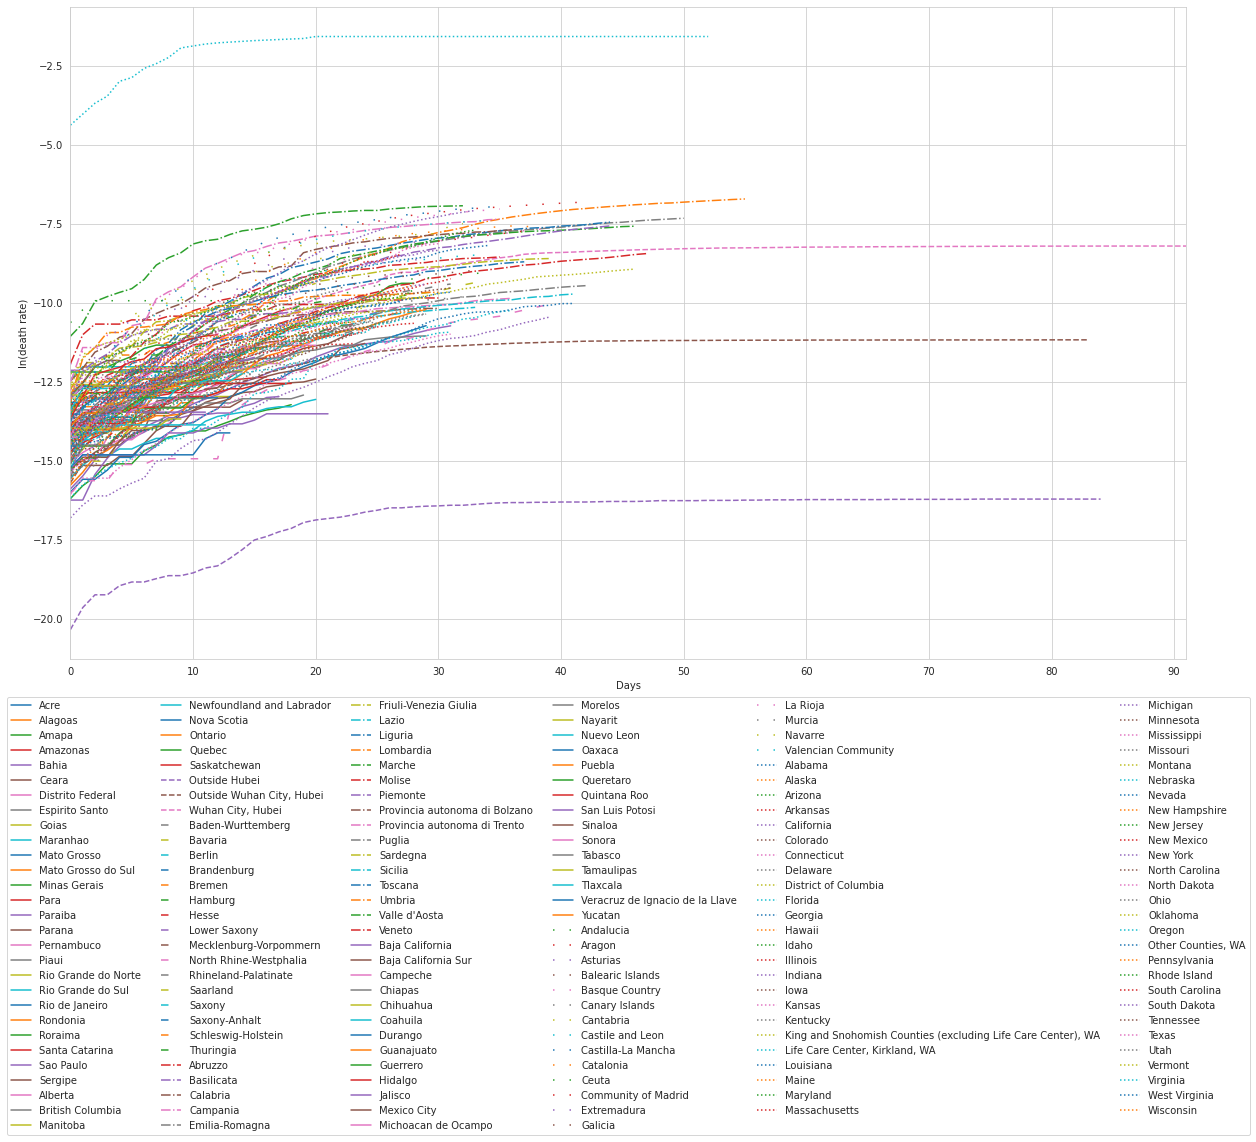

In [4]:
# come up with more informative names...
input_full_df = get_input_data('full_data', DATA_VERSION)
input_death_df = get_input_data('deaths', DATA_VERSION)
# # Dropping recent Montana data due to slow growth resulting in implausible backcast
# input_death_df = input_death_df.loc[(input_death_df['Location']!="Montana") | (input_death_df['Date'] < pd.Timestamp("2020-04-01"))]
input_age_pop_df = get_input_data('age_pop', DATA_VERSION)
input_age_death_df = get_input_data('age_death', DATA_VERSION)

# drop Georgia the country until we fix location_ids
input_full_df = input_full_df[input_full_df['Country/Region'] != 'Georgia'].reset_index(drop=True)
input_death_df = input_death_df[input_death_df['Country/Region'] != 'Georgia'].reset_index(drop=True)

# # read in cov input file (predicted date of R0 == 1) to see if we are using these for a given location
# cov_df = pd.read_csv(R0_FILE)
# r0_locs = cov_df['location_id'].unique().tolist()
# del cov_df
r0_locs = []

# # less conservative peak ranges
# peak_dur_df = pd.read_csv(PEAK_DURATION_FILE)
# peak_dur_df = peak_dur_df.loc[peak_dur_df['Location'] != 'Colorado']
# peak_dur_df['peak start date'] = pd.to_datetime(peak_dur_df['peak start date'])
# peak_dur_df['peak end date'] = pd.to_datetime(peak_dur_df['peak end date'])

# plot
plot_crude_rates(input_death_df, level='subnat')


## store pops for bobby

In [5]:
get_input_data('us_pops').to_csv(f'{OUTPUT_DIR}/pops.csv', index=False)


## combine back-casted death rates with cases for abie (using model dataset, i.e. admin1 and below)

In [6]:
%%capture
location_ids = sorted(input_full_df.loc[(np.log(input_full_df['Death rate']) > RATE_THRESHOLD) &
                                        (~input_full_df['Province/State'].isnull()), 
                                        'location_id'].unique())

start_time = datetime.now()
def combine_cases_w_backcast_deaths(location_id, input_death_df, input_age_pop_df, input_age_death_df, rate_threshold):
    mod_df = DeathModelData(input_death_df, input_age_pop_df, input_age_death_df, location_id, 'threshold', subnat=True, rate_threshold=RATE_THRESHOLD).df
    mod_df = mod_df.loc[mod_df['location_id'] == location_id].reset_index(drop=True)
    if len(mod_df) > 0:
        date0 = mod_df['Date'].min()
        day0 = mod_df.loc[~mod_df['Date'].isnull(), 'Days'].min()
        mod_df.loc[mod_df['Days'] == 0, 'Date'] = date0 - timedelta(days=np.round(day0))
        mod_df = mod_df.loc[~((mod_df['Deaths'].isnull()) & (mod_df['Date'] == date0))]
        mod_df = mod_df.loc[~mod_df['Date'].isnull()]
        mod_df.loc[mod_df['Death rate'].isnull(), 'Death rate'] = np.exp(mod_df['ln(age-standardized death rate)'])
        mod_df.loc[mod_df['Deaths'].isnull(), 'Deaths'] = mod_df['Death rate'] * mod_df['population']
        mod_df = mod_df.rename(index=str, columns={'Location':'Province/State'})
    else:
        mod_df = pd.DataFrame(
            columns=['location_id', 'Province/State', 'Country/Region', 'Date', 'Deaths', 'Death rate', 'population']
        )

    return mod_df[['location_id', 'Province/State', 'Country/Region', 'Date', 'Deaths', 'Death rate', 'population']].reset_index(drop=True)

_combiner = functools.partial(combine_cases_w_backcast_deaths, 
                              input_death_df=input_death_df, 
                              input_age_pop_df=input_age_pop_df, 
                              input_age_death_df=input_age_death_df, 
                              rate_threshold=RATE_THRESHOLD)
pool = Pool(20)
loc_dfs = pool.map(_combiner, location_ids)
pool.close()
pool.join()
loc_df = pd.concat(loc_dfs)
loc_df = input_full_df[['location_id', 'Province/State', 'Country/Region', 'Date', 'Confirmed', 'Confirmed case rate']].merge(
    loc_df, how='outer'
).reset_index(drop=True)
loc_df.loc[loc_df['Province/State'].isnull(), 'Province/State'] = loc_df['Country/Region']
loc_df['location_id'] = loc_df['location_id'].astype(int)
loc_df.to_csv(f'{OUTPUT_DIR}/backcast_for_case_to_death.csv', index=False)


In [7]:
date_df = impute_death_threshold(loc_df,
                                 location_list=loc_df.loc[(loc_df['Country/Region'] == 'United States of America') &
                                                          (~loc_df['Province/State'].isnull()), 'Province/State'].unique().tolist(),
                                 ln_death_rate_threshold=RATE_THRESHOLD)
loc_df = loc_df[['location_id', 'Province/State']].drop_duplicates()
loc_df = loc_df.rename(index=str, columns={'Province/State':'location'})
date_df = loc_df.merge(date_df)
date_df.to_csv(f'{OUTPUT_DIR}/threshold_dates.csv', index=False)
del loc_df
end_time = datetime.now()
print(end_time - start_time)


0:04:03.322703


## create datasets for each subnational unit of US

In [8]:
# get location information
loc_df = get_location_metadata(location_set_id=35, gbd_round_id=6)
location_ids = loc_df.loc[(loc_df['parent_id'] == 102) & (loc_df['location_name'] != 'Washington'), 
                          'location_id'].to_list()
location_names = loc_df.loc[(loc_df['parent_id'] == 102) & (loc_df['location_name'] != 'Washington'), 
                           'location_name'].to_list()
for wa_location in ['Other Counties, WA',
                    'King and Snohomish Counties (excluding Life Care Center), WA', 
                    'Life Care Center, Kirkland, WA']:
    location_ids += [input_full_df.loc[input_full_df['Province/State'] == wa_location, 'location_id'].astype(int).unique().item()]
    location_names += [wa_location]

## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
## NEED TO ADD OPTION TO ADD NEW YORK + MIAMI (UNTIL WE MOVE TO LOCATION HIERARCHY)
## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

# method for getting dates
def date_mean(dates):
    dt_min = dates.min()
    deltas = [x-dt_min for x in dates]

    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

# get mean data from dataset
date_draws = [i for i in date_df.columns if i.startswith('death_date_draw_')]
date_mean_df = date_df.copy()
date_mean_df['threshold_date'] = date_mean_df.apply(
    lambda x: datetime.strptime(date_mean(x[date_draws]).strftime('%Y-%m-%d'), '%Y-%m-%d'),
    axis=1
)
date_mean_df['Country/Region'] = 'United States of America'
date_mean_df = date_mean_df.rename(index=str, columns={'location':'Location'})
date_mean_df = date_mean_df[['location_id', 'Location', 'Country/Region', 'threshold_date']]

# set up ensemble
def get_out_dirs(model_labels):
    model_out_dirs = []
    for model_label in model_labels:
        for k in KS:
            # set up dirs
            model_out_dir = f'{OUTPUT_DIR}/model_data_{model_label}_{k}'
            if not os.path.exists(model_out_dir):
                os.mkdir(model_out_dir)
            model_out_dirs.append(model_out_dir)
            
    return model_out_dirs
def get_draw_list(n_scenarios):
    n_draws_list = [int(1000 / n_scenarios)] * n_scenarios
    n_draws_list[-1] = n_draws_list[-1] + 1000 - np.sum(n_draws_list)
    
    return n_draws_list

# prepare last day dataset
last_day_df = input_full_df.copy()
last_day_df['last_day'] = last_day_df.groupby('location_id', as_index=False)['Date'].transform(max)
last_day_df = last_day_df.loc[last_day_df['Date'] == last_day_df['last_day']].reset_index(drop=True)
last_day_df['location_id'] = last_day_df['location_id'].astype(int)
last_day_df.loc[last_day_df['Death rate'] == 0, 'Death rate'] = 0.1 / last_day_df['population']
last_day_df['ln(death rate)'] = np.log(last_day_df['Death rate'])
last_day_df = last_day_df[['location_id', 'ln(death rate)', 'Date']].merge(date_mean_df)
last_day_df['Days'] = (last_day_df['Date'] - last_day_df['threshold_date'])
last_day_df['Days'] = last_day_df['Days'].apply(lambda x: x.days)
last_day_df = last_day_df.loc[last_day_df['Days'] > 0]
last_day_df[['location_id', 'ln(death rate)', 'Days']].to_csv(f'{OUTPUT_DIR}/last_day.csv', index=False)

# read in data for cases-to-deaths
cases_deaths_df = pd.read_csv(CASES_DEATHS_FILE)
cases_deaths_df['Date'] = pd.to_datetime(cases_deaths_df['Date'])

# submit models
submodel_dict = {}
N = len(location_ids)
i = 0
nursing_home_locations = ['Life Care Center, Kirkland, WA']
for location_id, location_name in zip(location_ids, location_names):
    i += 1
    print(f'{i} / {N} locations')
    mod = DeathModelData(input_death_df, input_age_pop_df, input_age_death_df, location_id, 'threshold', subnat=True, rate_threshold=RATE_THRESHOLD)
    if location_name in nursing_home_locations:
        # save only nursing homes
        mod_df = mod.df.copy()
    else:
        # save only others
        mod_df = mod.df.loc[~mod.df['Location'].isin(nursing_home_locations)].reset_index(drop=True)
    # drop back-cast
    mod_df = mod_df.loc[~(mod_df['Deaths'].isnull())].reset_index(drop=True)
    
    # flag as true data
    mod_df['pseudo'] = 0
    
    # tack on deaths from cases if in dataset
    if location_id in input_full_df['location_id'].tolist() and \
        location_id not in [564, 538]:  # South Dakota, Iowa
        # get future days
        last_date = input_full_df.loc[input_full_df['location_id'] == location_id, 'Date'].max()
        loc_cd_df = cases_deaths_df.loc[(cases_deaths_df['location_id'] == location_id) &
                                        (cases_deaths_df['Date'] > last_date)].reset_index(drop=True)
        loc_cd_df['population'] = input_full_df.loc[input_full_df['location_id'] == location_id, 
                                                    'population'].max()  # all the same...
        loc_cd_df['pseudo'] = 1
        
        # convert to days
        if location_id in mod_df['location_id'].tolist():
            last_day = mod_df.loc[mod_df['location_id'] == location_id, 'Days'].max()
            loc_cd_df['Days'] = last_day + 1 + loc_cd_df.index
        else:
            threshold = date_mean_df.loc[date_mean_df['location_id'] == location_id, 'threshold_date'].item()
            loc_cd_df['Days'] = loc_cd_df['Date'].apply(lambda x: (x - threshold).days)
        loc_cd_df = loc_cd_df.loc[loc_cd_df['Days'] >= 0]
            
        # stick on to dataset
        mod_df = mod_df.append(loc_cd_df)
        mod_df = mod_df.sort_values(['location_id', 'Days']).reset_index(drop=True)
    
    # figure out which models we are running (will need to check about R0=1 model)
    submodels = MOBILITY_SOURCES.copy()
    if location_id in r0_locs:
        submodels += ['R0_35', 'R0_50', 'R0_65']
    submodel_dirs = get_out_dirs(submodels)
    
    # how many draws for each
    n_draws_list = get_draw_list(n_scenarios=len(submodel_dirs))
    
    # store this information
    submodel_dict.update({
        int(location_id):{
            'submodel_dirs':submodel_dirs,
            'n_draws_list':n_draws_list
        }
    })
    
    # run models
    n_i = 0
    for cov_source in submodels:
        if cov_source in MOBILITY_SOURCES:
            covariate_effect = 'gamma'
        else:
            covariate_effect = 'beta'
        for k in KS:
            # drop back-cast for modeling file, but NOT for the social distancing covariate step
            model_out_dir = f'{OUTPUT_DIR}/model_data_{cov_source}_{k}'
            mod_df.to_csv(f'{model_out_dir}/{location_name}.csv', index=False)
            sd_cov = SocialDistCov(mod_df, date_mean_df, data_version=DATA_VERSION)
            if cov_source in MOBILITY_SOURCES:
                sd_cov_df = sd_cov.get_cov_df(weights=[None], k=k, empirical_weight_source=cov_source)
            else:
                sd_cov_df = sd_cov.get_cov_df(weights=[None], k=k, empirical_weight_source=cov_source, R0_file=R0_FILE)
            sd_cov_df.to_csv(f'{model_out_dir}/{location_name} covariate.csv', index=False)
            if not os.path.exists(f'{model_out_dir}/{location_name}'):
                os.mkdir(f'{model_out_dir}/{location_name}')
            submit_curvefit(job_name=f'curve_model_{location_id}_{cov_source}_{k}',
                            location_id=location_id, 
                            code_dir=CODE_DIR,
                            model_location=location_name,
                            model_location_id=location_id,
                            data_file=f'{model_out_dir}/{location_name}.csv', 
                            cov_file=f'{model_out_dir}/{location_name} covariate.csv', 
                            last_day_file=f'{OUTPUT_DIR}/last_day.csv',
                            peaked_file=PEAK_FILE,
                            output_dir=f'{model_out_dir}/{location_name}',
                            covariate_effect=covariate_effect,
                            n_draws=n_draws_list[n_i],
                            python=shutil.which('python'),
                            verbose=False)
            n_i += 1


1 / 53 locations
Only using admin1 and below locations
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 523
Fix backcasting if we change nursing home observations (drop by name).
Your job 39558934 ("curve_model_523_google_21") has been submitted

Your job 39558935 ("curve_model_523_descartes_21") has been submitted

Your job 39558936 ("curve_model_523_safegraph_21") has been submitted

2 / 53 locations
Only using admin1 and below locations
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 524
Fix backcasting if we change nursing home observations (drop by name).
Your job 39558937 ("curve_model_524_google_21") has been submitted

Your job 39558938 ("curve_model_524_descartes_21") has been submitted

Your job 39558939 ("curve_model_524_safegraph_21") has been submitted

3 / 53 locations
Only using admin1 and below locations
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population o

## compile draws

    Waiting for /ihme/covid-19/deaths/prod/2020_04_18_US/model_data_google_21/Georgia/draws.pkl...


KeyboardInterrupt: 

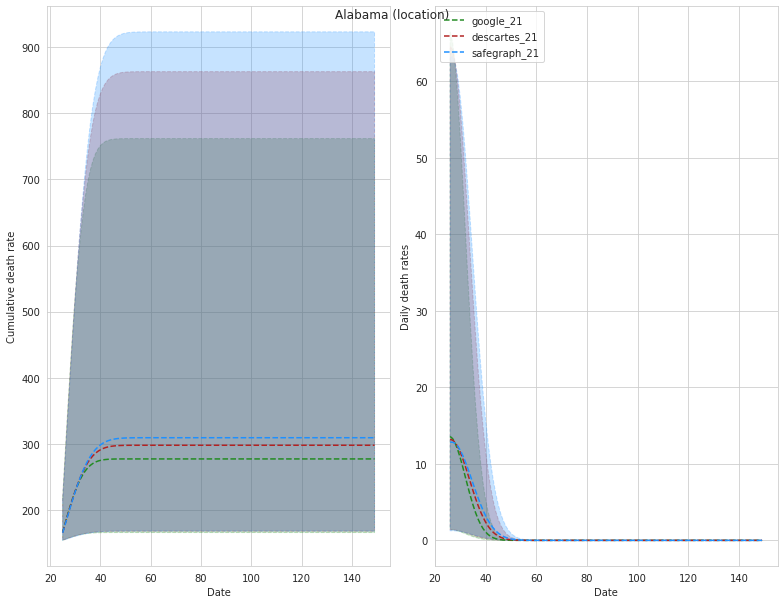

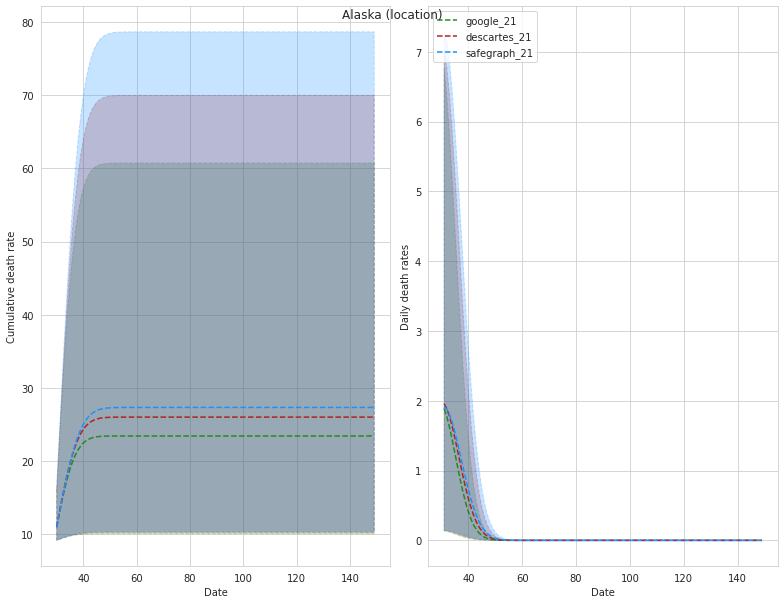

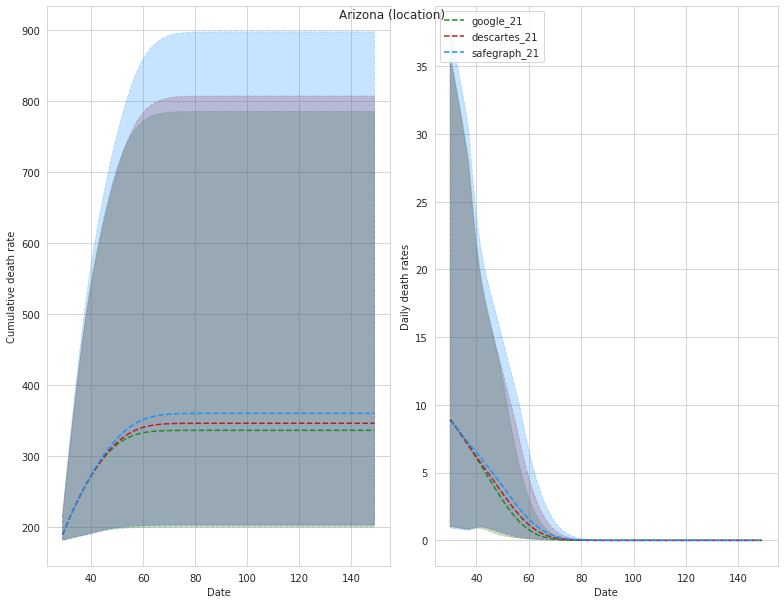

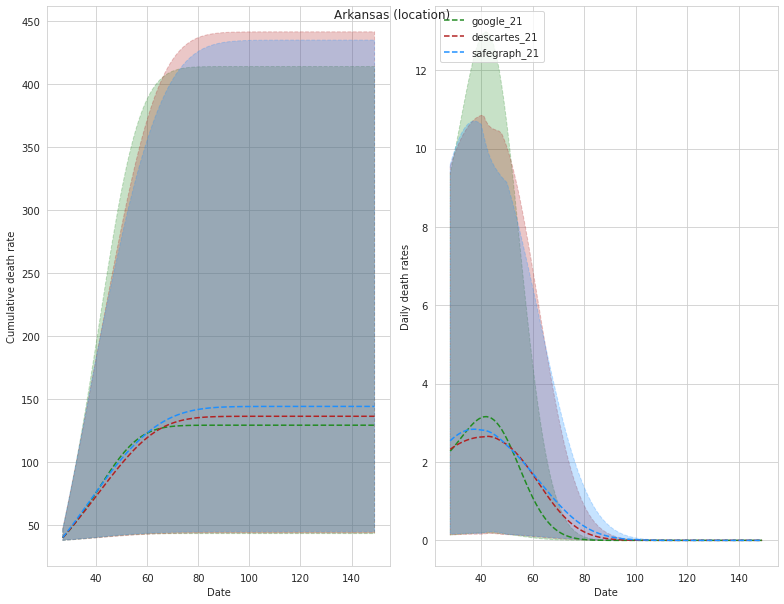

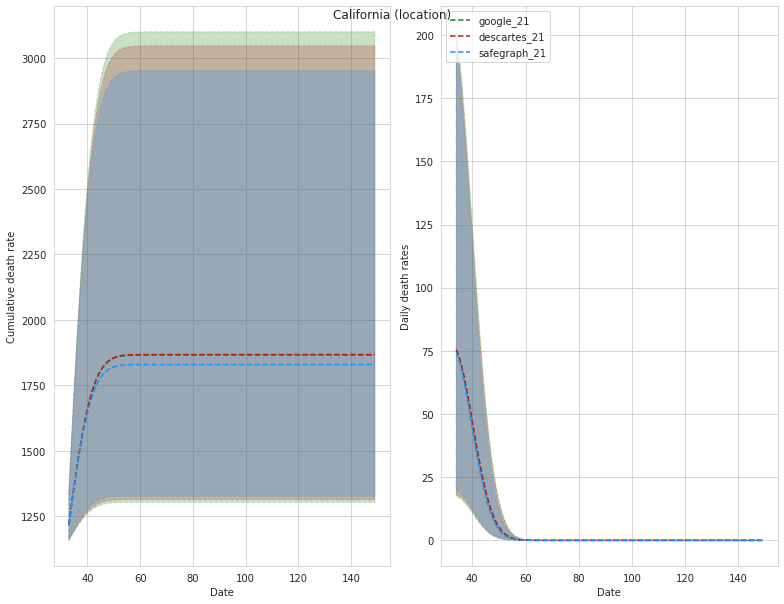

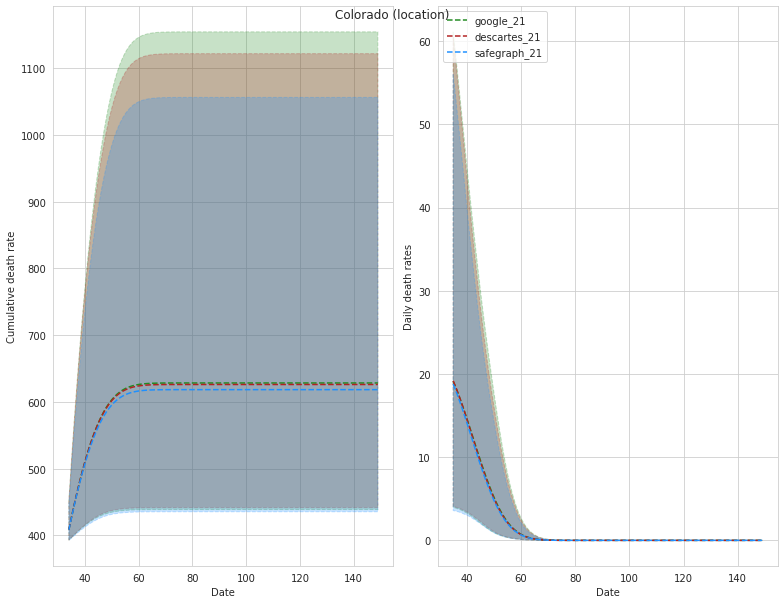

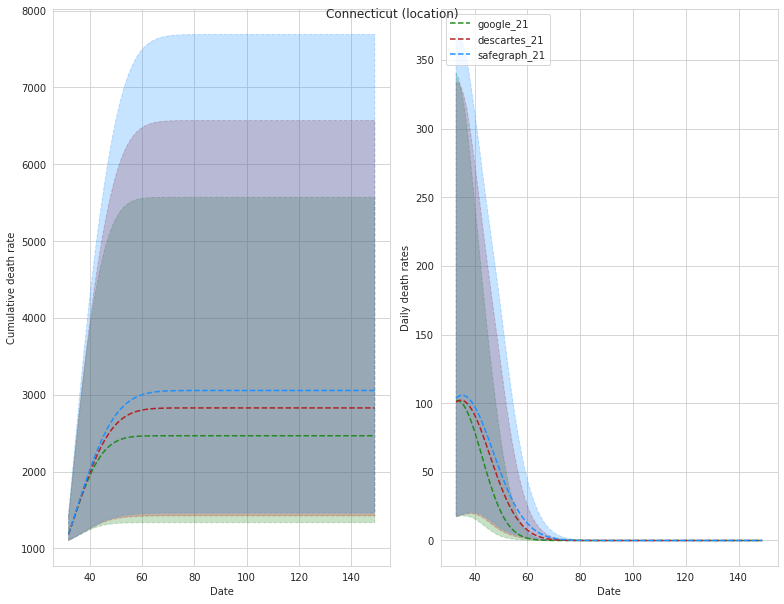

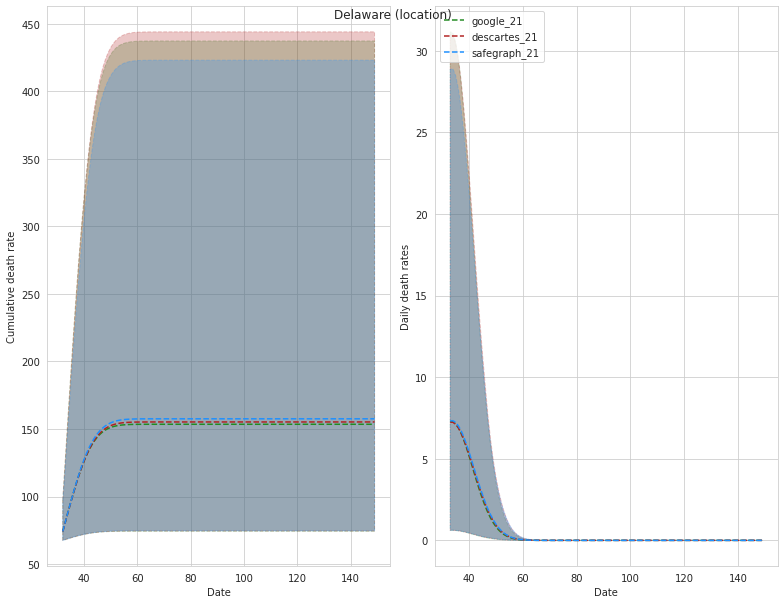

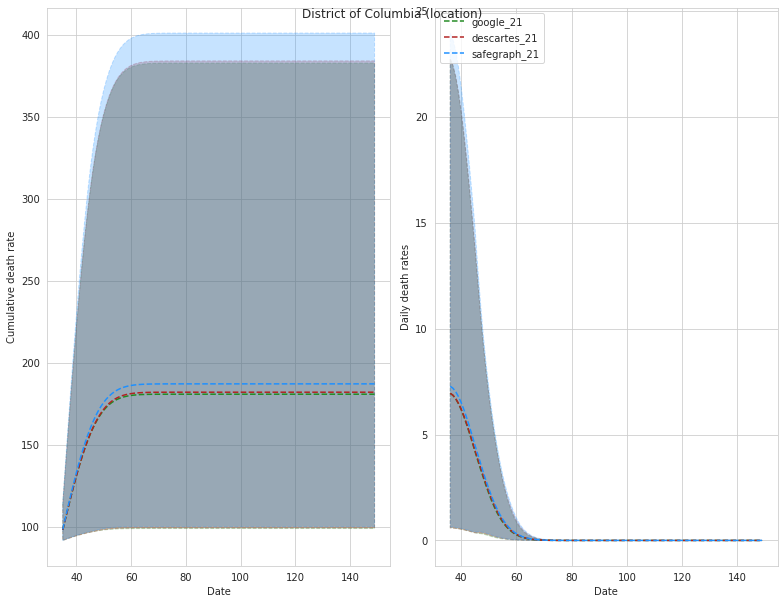

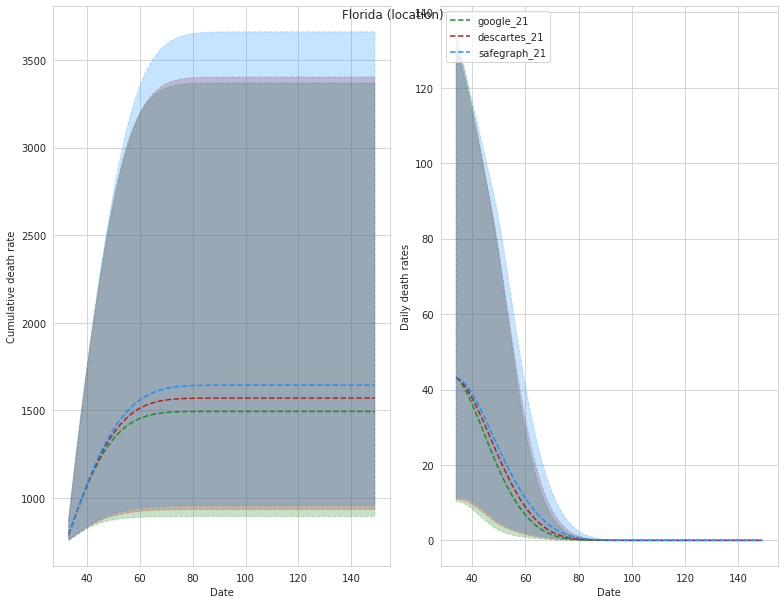

In [9]:
# subset US
usa_obs_df = input_full_df[(input_full_df['Country/Region'] == 'United States of America') & 
                           (~input_full_df['Province/State'].isnull())]

# combine everything
draw_dfs = []
past_draw_dfs = []
models_used = []
with PdfPages(f'{OUTPUT_DIR}/ensemble_plot.pdf') as pdf:
    for location_id, location_name in zip(location_ids, location_names):
        # # identify peak duration
        # if int(location_id) in peak_dur_df['location_id'].to_list():
        #     print(f'{location_name}: observed peak')
        #     peak_duration = peak_dur_df.loc[peak_dur_df['location_id'] == int(location_id), 'peak durations'].item()
        # else:
        #     print(f'{location_name}: average peak')
        #     peak_duration = 5
        # peak_duration = int(np.round(peak_duration))
        # print(f'Peak length: {peak_duration}')
        peak_duration = 1
        # get draws
        data_draws = Drawer(
            ensemble_dirs=submodel_dict[int(location_id)]['submodel_dirs'],
            n_draws_list=submodel_dict[int(location_id)]['n_draws_list'],
            location_name=location_name, 
            location_id=int(location_id), 
            peak_duration=peak_duration,
            obs_df=usa_obs_df.loc[usa_obs_df['location_id'] == int(location_id)],
            date_draws=date_df.loc[date_df['location'] == location_name, date_draws].values, 
            population=input_age_pop_df.loc[input_age_pop_df['location_id'] == int(location_id), 'population'].sum()
        )
        draw_df, past_draw_df, model_used, days, ensemble_draws = data_draws.get_dated_draws()
        draw_dfs.append(draw_df)
        past_draw_dfs.append(past_draw_df)
        models_used.append(model_used)

        # plot ensemble
        fig, ax = plt.subplots(1, 2, figsize=(11, 8.5))
        for label, draws in ensemble_draws.items():
            label = label.split('model_data_')[1]
            draws = np.exp(draws) * input_age_pop_df.loc[input_age_pop_df['location_id'] == int(location_id), 'population'].sum()
            deaths_mean = draws.mean(axis=0)
            deaths_lower = np.percentile(draws, 2.5, axis=0)
            deaths_upper = np.percentile(draws, 97.5, axis=0)

            d_deaths_mean = (draws[:,1:] - draws[:,:-1]).mean(axis=0)
            d_deaths_lower = np.percentile(draws[:,1:] - draws[:,:-1], 2.5, axis=0)
            d_deaths_upper = np.percentile(draws[:,1:] - draws[:,:-1], 97.5, axis=0)

            # cumulative
            ax[0].fill_between(days,
                               deaths_lower, deaths_upper,
                               color=COLOR_DICT['_'.join(label.split('_')[:-1])], 
                               linestyle=LINE_DICT[label.split('_')[-1]], 
                               alpha=0.25)
            ax[0].plot(days, deaths_mean, 
                       c=COLOR_DICT['_'.join(label.split('_')[:-1])], 
                       linestyle=LINE_DICT[label.split('_')[-1]])
            ax[0].set_xlabel('Date')
            ax[0].set_ylabel('Cumulative death rate')

            # daily
            ax[1].fill_between(days[1:],
                               d_deaths_lower, d_deaths_upper,
                               color=COLOR_DICT['_'.join(label.split('_')[:-1])], 
                               linestyle=LINE_DICT[label.split('_')[-1]], 
                               alpha=0.25)
            ax[1].plot(days[1:], d_deaths_mean, 
                       c=COLOR_DICT['_'.join(label.split('_')[:-1])], 
                       linestyle=LINE_DICT[label.split('_')[-1]], 
                       label=label.replace('model_data_', ''))
            ax[1].set_xlabel('Date')
            ax[1].set_ylabel('Daily death rates')

        ax[1].legend(loc=2)
        plt.suptitle(f'{location_name} ({model_used})')
        plt.tight_layout()
        pdf.savefig()
if 'location' not in models_used:
    raise ValueError('No location-specific draws used, must be using wrong tag')
draw_df = pd.concat(draw_dfs)
model_type_df = pd.DataFrame({
    'location':location_names,
    'model_used':models_used
})

# write
draw_df.to_csv(f'{OUTPUT_DIR}/state_data.csv', index=False)
model_type_df.to_csv(f'{OUTPUT_DIR}/state_models_used.csv', index=False)
print(f'{OUTPUT_DIR}/state_data.csv')


## total US deaths in this run

In [ ]:
draw_cols = [f'draw_{i}' for i in range(1000)]
nat_df = draw_df.groupby('date', as_index=False)[draw_cols].sum()
nat_df = nat_df.loc[nat_df['date'] == pd.Timestamp('2020-07-15')]
deaths_mean = int(nat_df[draw_cols].mean(axis=1).item())
deaths_lower = int(np.percentile(nat_df[draw_cols], 2.5, axis=1).item())
deaths_upper = int(np.percentile(nat_df[draw_cols], 97.5, axis=1).item())
f'{deaths_mean:,} ({deaths_lower:,} - {deaths_upper:,})'


## combine with previous predictions

In [ ]:
# ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
# raw_draw_path = f'{OUTPUT_DIR}/state_data.csv'
# average_draw_path = f'{OUTPUT_DIR}/past_avg_state_data.csv'
# yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_10_US/state_data.csv'
# before_yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_09_US/state_data.csv'
# ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

# avg_df = moving_average_predictions(
#     'US', 
#     specified=True,
#     model_1=raw_draw_path,
#     model_2=yesterday_draw_path,
#     model_3=before_yesterday_draw_path
# )
# avg_df['date'] = pd.to_datetime(avg_df['date'])
# past_draw_df = pd.concat(past_draw_dfs)

# ## NO NEED TO DO THIS, FOR NOW ##
# # avg_df = get_peak_date(past_draw_df, avg_df)

# # store data
# avg_df.to_csv(average_draw_path, index=False)
# print(average_draw_path)

# # plot
# plotter = CompareAveragingModelDeaths(
#     raw_draw_path=raw_draw_path,
#     average_draw_path=average_draw_path,
#     yesterday_draw_path=yesterday_draw_path,
#     before_yesterday_draw_path=before_yesterday_draw_path
#     )
# plotter.make_some_pictures(f'{OUTPUT_DIR}/moving_average_compare.pdf',
#                            'United States of America')


In [ ]:
plotter = CompareModelDeaths(
    old_draw_path='/ihme/covid-19/deaths/prod/2020_04_16_US/state_data.csv',
    new_draw_path=f'{OUTPUT_DIR}/state_data.csv'
)
plotter.make_some_pictures(f'{OUTPUT_DIR}/compare_to_previous.pdf',
                           'United States of America')


In [ ]:

viz_dir = f'/home/j/Project/covid/results/diagnostics/deaths/{DATESTAMP_LABEL}/'
if not os.path.exists(viz_dir):
    os.mkdir(viz_dir)
for viz_fp in ['compare_to_previous.pdf','ensemble_plot.pdf']:  # ,'moving_average_compare.pdf'
    shutil.copyfile(src=f"{OUTPUT_DIR}/{viz_fp}", dst=f"{viz_dir}/{viz_fp}")


In [ ]:
print(viz_dir)